In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, gc, gzip, pickle, json
from datetime import datetime

from tensorflow.keras.backend import clear_session
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append('../') #to see the utils folder
from utils.STResNet import Classifier as STResNet

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

#set a nice seaborn style
import seaborn as sns
sns.set_style("darkgrid")


In [7]:
#prinf libraries versions
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('tensorflow version: ', tf.__version__)
#python 3.9.15
import sklearn
print('sklearn version: ', sklearn.__version__)


numpy version:  1.26.2
pandas version:  1.5.3
tensorflow version:  2.13.1
sklearn version:  1.2.2


In [8]:
# Create temp notebook folder if it does not exist
TEMP_FOLDER = 'temp/7_end_to_end_train_eval'
if(not os.path.exists(TEMP_FOLDER)):
    os.mkdir(TEMP_FOLDER)

In [ ]:
#generate LSTM model with 2 lstm layers using keras functional API
def generate_LSTM (input_shape, output_shape, num_LSTM_layers=2, num_units=64, dropout=0.2, recurrent_dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    #add 1d batch normalization

    x = inputs
    for i in range(num_LSTM_layers):
        x = tf.keras.layers.LSTM(num_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.LSTM(num_units, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#generate Convolutional model with 3 CNN and one fully conencted using keras functional API
def generate_CNN (input_shape, output_shape, num_CNN_layers=3, num_units=64, dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_CNN_layers):
        x = tf.keras.layers.Conv1D(filters=num_units, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#generate ConvLSTM mode with 3 CNN layers and 1 LSTM layers using keras functional API
def generate_ConvLSTM (input_shape, output_shape, num_CNN_layers=3, num_units=64, dropout=0.2, recurrent_dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_CNN_layers):
        x = tf.keras.layers.Conv1D(filters=num_units, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.LSTM(num_units, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



#generate transofrmer model with 3 layers for a multi channel input using keras functional API
def generate_transformer (input_shape, output_shape, num_heads=2, num_transformer_blocks=2, num_units=16, dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_transformer_blocks):
        x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_units, dropout=dropout)(x, x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



#generate STResnet model
def generate_STResnet(signal_size,num_channels,sampling_rate,num_classes):
    clear_session()

    signal_sizes = [signal_size]*num_channels #in this case the signal size is the same for all channels, but the model aloows different sizes
    sampling_rates = [sampling_rate]*num_channels #in this case the sampling rate is the same for all channels, but the model aloows different sizes
    fft_win_len_factor = 30 #len of fft windows in seconds
    fft_win_length = []
    hop_length = [] 

    for i in range(len(signal_sizes)):
            fft_win_length.append(sampling_rates[i]*fft_win_len_factor)
            hop_length.append(int(fft_win_length[i]//2))

    model_config = []
    with open("../utils/STResNet_config.json") as json_file: 
            model_config = json.load(json_file)
            model_config['signal_size'] = signal_sizes
            model_config['num_channels'] = len(signal_sizes) 
            model_config['sampling_rate'] = sampling_rates
            
            model_config['fft_win_length'] = fft_win_length
            model_config['hop_length'] = hop_length
            model_config['max_filters'] = 32
            model_config['num_filters'] = 16
            model_config['num_res_blocks'] = 4

    STResNet_model = STResNet(model_config,num_classes,verbose = 1)
    
    return STResNet_model.model


In [ ]:
SAMPLING_RATE = 10

INFO_COLUMNS = ['Participant_No', 'Condition', 'Segment','Time']
EMG_AMP_COLUMNS = ['Emg/Amplitude[RightOrbicularis]',
               'Emg/Amplitude[RightZygomaticus]',
               'Emg/Amplitude[RightFrontalis]',
               'Emg/Amplitude[CenterCorrugator]',
               'Emg/Amplitude[LeftFrontalis]',
               'Emg/Amplitude[LeftZygomaticus]',
               'Emg/Amplitude[LeftOrbicularis]']
EMG_CONTACT_COLUMNS = ['Emg/Contact[RightOrbicularis]',
               'Emg/Contact[RightZygomaticus]',
               'Emg/Contact[RightFrontalis]',
               'Emg/Contact[CenterCorrugator]',
               'Emg/Contact[LeftFrontalis]',
               'Emg/Contact[LeftZygomaticus]',
               'Emg/Contact[LeftOrbicularis]']
HR_COLUMNS = ['HeartRate/Average', 'Ppg/Raw.ppg']
IMU_COLUMNS = ['Accelerometer/Raw.x', 'Accelerometer/Raw.y', 'Accelerometer/Raw.z', 
               'Gyroscope/Raw.x', 'Gyroscope/Raw.y', 'Gyroscope/Raw.z']
EYE_COLUMNS = ['VerboseData.Right.PupilDiameterMm','VerboseData.Left.PupilDiameterMm']
BIOPAC_RR_COLUMNS = ['Biopac_RSP']
BIOPAC_GSR_COLUMNS = ['Biopac_GSR']
SENSOR_COLUMNS = EMG_AMP_COLUMNS + EMG_CONTACT_COLUMNS + HR_COLUMNS + IMU_COLUMNS + EYE_COLUMNS + BIOPAC_RR_COLUMNS + BIOPAC_GSR_COLUMNS

ALL_COLUMNS = INFO_COLUMNS + SENSOR_COLUMNS

PROCESSED_DATA_FOLDER = 'temp/6_end_to_end_preprocess_data'


#load segments and labels
#with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_all_sensor_dict.pkl.gz'), 'rb') as f:
#    segments_sensor_dict = pickle.load(f)
#with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_hr_dict.pkl.gz'), 'rb') as f:
#    segments_sensor_dict = pickle.load(f)
with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_labels_dict.pkl.gz'), 'rb') as f:
    segments_labels_dict = pickle.load(f)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




In [ ]:
TF_DEVICE = "0"
def my_set_session():
    os.environ["CUDA_VISIBLE_DEVICES"] = TF_DEVICE
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True) #allocte memory as needed
        memory_growth = tf.config.experimental.get_memory_growth(gpu)
        print(f"Memory growth for GPU {gpu.name}: {memory_growth}")
    return()
    
my_set_session()

In [ ]:
#plot model shapes 
model = generate_LSTM(input_shape=(100, 3), output_shape=2)
#print only model parameters
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
#plot model shapes 
model = generate_CNN(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
#plot model shapes 
model = generate_ConvLSTM(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#plot model shapes 
model = generate_transformer(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
##plot STResNet shapes 
model = generate_STResnet(signal_size=100,num_channels=3,sampling_rate=10,num_classes=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)



In [ ]:
def train_evaluate_DL_model(X_train,y_train,
                            X_valid,y_valid,
                            X_test,y_test,
                            model_func,model_name):
    batch_size = 512
    epochs = 150
    num_classes = len(np.unique(y_train))
    output_shape = num_classes

  
    metric = 'val_accuracy' #STResNet names val_acc, others val_accuracy
    if model_name == 'STResNet':
        model = model_func(signal_size = X_train[0].shape[-1],
                           num_channels = len(X_train),
                           sampling_rate = SAMPLING_RATE,
                           num_classes=num_classes)
        metric = 'val_acc'
    else:
        input_shape = X_train.shape[1:]
        model = model_func(input_shape, output_shape)
    
  #define callbacks for model checkpointing 
    model_path = './models/'+model_name+'_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                                     monitor=metric,
                                                                        mode='max',
                                                                        verbose=0,
                                                                        save_best_only=True)

    history = model.fit(X_train, y_train, 
                             epochs=epochs, 
                             validation_data=(X_valid, y_valid),
                             batch_size=batch_size,
                                callbacks=[model_checkpoint_callback],
                             verbose=0, shuffle=True)
    #load best model
    model.load_weights(model_path)

    #evaluate model
    y_pred_onehot = model.predict(X_test,verbose=0)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_test = np.argmax(y_test, axis=1)
    test_acc = accuracy_score(y_test, y_pred).round(2)

    #validation accuracy
    y_pred_onehot = model.predict(X_valid,verbose=0)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    valid_acc = accuracy_score(y_valid, y_pred).round(2)
    print(datetime.now().strftime("%H:%M:%S"), 'Test acc:',test_acc, 'Valid acc:',valid_acc)

    del model

    return test_acc,y_pred_onehot, history.history


In [ ]:
def getColumnIndexRange(columnList):
    sensorIndexList = []
    for signalColumn in columnList:
        sensorIndexList.append(SENSOR_COLUMNS.index(signalColumn))
    return sensorIndexList

In [ ]:
#modalities = {
#    'EMG_A': EMG_AMP_COLUMNS,
#    'EMG_C': EMG_CONTACT_COLUMNS , 
#    'HR': HR_COLUMNS,
#    'IMU': IMU_COLUMNS ,
#    'PupilSize': EYE_COLUMNS ,
#    'GSR': BIOPAC_GSR_COLUMNS ,
#    'RSP': BIOPAC_RR_COLUMNS ,
#    'ALL': SENSOR_COLUMNS 
#}

modalities = {
    'EMG_A': 'segments_emg_amp_dict.pkl.gz',
    'EMG_C': 'segments_emg_contact_dict.pkl.gz' , 
    'HR': 'segments_hr_dict.pkl.gz',
    'IMU': 'segments_imu_dict.pkl.gz' ,
    'PupilSize': 'segments_eye_dict.pkl.gz' ,
    'GSR': 'segments_gsr_dict.pkl.gz' ,
    'RSP': 'segments_rr_dict.pkl.gz' ,
    'ALL': 'segments_all_sensor_dict.pkl.gz' 
}

#functions thatinitiate models
model_functions = {'STResNet': generate_STResnet,
                   'CNN': generate_CNN, 
    'ConvLSTM': generate_ConvLSTM,
     'LSTM': generate_LSTM,
    'Transformer': generate_transformer,
    }


In [ ]:
# Main ML training loop
for modality in modalities:
    # if modality in ['EMG_A', 'EMG_C']:
    #     continue
    print('Running for: ' + modality)
    #get index of desired signal columns

    data_file = os.path.join(PROCESSED_DATA_FOLDER, modalities[modality])
    with gzip.open(data_file, 'rb') as f:
        print('Loading file: ' + data_file)
        segments_sensor_dict = pickle.load(f)

    #create 5 folds of non-overalpping user ids for person-independent 5-fold cross validation
    users = list(segments_sensor_dict.keys())
    np.random.shuffle(users)
    folds = np.array_split(users, 5)



    test_acc_dict = {}
    history_dict = {}
    users = list(segments_sensor_dict.keys())
    for model_name, model_func in model_functions.items(): 
        if model_name == 'LSTM':
            continue
        print('-------model: ', model_name)
        test_acc_arr = []
        test_predictions_arr = []
        train_history_arr = []

        for test_users in folds:
            print('test users: ', test_users)
            #split data into train and test
            X_train = []
            y_train = []
            X_valid = []
            y_valid = []
            X_test = []
            y_test = []

            validation_counter = 0
            num_validation_users = 5
            for user in users:
                if user in test_users:
                    X_test.extend(np.array(segments_sensor_dict[user])) #select only columns we want to use as input
                    y_test.extend(segments_labels_dict[user]) 
                else:
                    validation_counter += 1
                    if validation_counter <= num_validation_users: #use first n users for validations
                        X_valid.extend(np.array(segments_sensor_dict[user]))
                        y_valid.extend(segments_labels_dict[user])
                    else:
                        X_train.extend(np.array(segments_sensor_dict[user])) #select only columns we want to use as input
                        y_train.extend(segments_labels_dict[user])
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            X_valid = np.array(X_valid)
            y_valid = np.array(y_valid)
            X_test = np.array(X_test)
            y_test = np.array(y_test)

            y_train = y_train[:,0] #the whole segment has the same label, so we can just take the first one
            y_valid = y_valid[:,0] #the whole segment has the same label, so we can just take the first one
            y_test = y_test[:,0] #the whole segment has the same label, so we can just take the first one

            #one-hot encode labels
            onehot_encoder = OneHotEncoder(sparse=False)
            y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
            y_valid = onehot_encoder.transform(y_valid.reshape(-1, 1))
            y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

            if model_name == 'STResNet':
                X_train = X_train.transpose(2,0,1)
                X_valid = X_valid.transpose(2,0,1)
                X_test = X_test.transpose(2,0,1)

                #convert data into a list of inputs suitable for STResNet
                X_train = [x for x in X_train]
                X_valid = [x for x in X_valid]
                X_test = [x for x in X_test]

            if test_users[0] == folds[0][0]: #print only once

                print('X_train shape: ', np.array(X_train).shape)
                print('X_valid shape: ', np.array(X_valid).shape)
                print('X_test shape: ', np.array(X_test).shape)
                print('y_train shape: ', y_train.shape)
                print('y_valid shape: ', y_valid.shape)
                print('y_test shape: ', y_test.shape)
                print()

            acc, test_predictions, history = train_evaluate_DL_model(X_train,y_train,
                                                                        X_valid,y_valid,
                                                                     X_test,y_test,
                                                                     model_func,model_name=model_name)
            clear_session()
            gc.collect()
            print()

            test_acc_arr.append(acc)
            test_predictions_arr.append(test_predictions)
            train_history_arr.append(history)

            del X_train, y_train, X_test, y_test, test_predictions, history
            gc.collect()


        #save results
        test_acc_dict[model_name] = test_acc_arr
        history_dict[model_name] = train_history_arr

        #save intermediate results            
        with open(os.path.join(TEMP_FOLDER,modality + '_test_acc_dict.pkl'), 'wb') as f:
            pickle.dump(test_acc_dict, f)    
        with open(os.path.join(TEMP_FOLDER,modality + '_test_predictions_arr.pkl'), 'wb') as f:
            pickle.dump(test_predictions_arr, f)
        with open(os.path.join(TEMP_FOLDER,modality + '_history_dict.pkl'), 'wb') as f:
            pickle.dump(history_dict, f)
    

In [9]:
def load_data(sensor_name):
    with open(os.path.join(TEMP_FOLDER, sensor_name + '_test_acc_dict.pkl'), 'rb') as f:
        test_acc_dict = pickle.load(f)
    with open(os.path.join(TEMP_FOLDER, sensor_name + '_history_dict.pkl'), 'rb') as f:
        history_dict = pickle.load(f)

    return test_acc_dict, history_dict

In [10]:

#ALL
ALL_test_acc_dict, ALL_history_dict = load_data('ALL')

#EMG A
emg_a_test_acc_dict, emg_a_history_dict = load_data('EMG_A')

#EMG C
emg_c_test_acc_dict, emg_c_history_dict = load_data('EMG_C')

#GSR
gsr_test_acc_dict, gsr_history_dict = load_data('GSR')

#HR
hr_test_acc_dict, hr_history_dict = load_data('HR')

#IMU
imu_test_acc_dict, imu_history_dict = load_data('IMU')

#PUPIL SIZE
ps_test_acc_dict, ps_history_dict = load_data('PupilSize')

#RSP
rsp_test_acc_dict, rsp_history_dict = load_data('RSP')

In [11]:
# Make a table with results per model with average and standard deviation
results_df = pd.DataFrame()

sensor_names = ['ALL', 'EMG_A', 'EMG_C', 'GSR', 'HR', 'IMU', 'PupilSize', 'RSP']

index_counter = 0

for sensor_name in sensor_names:
    # Load data
    test_acc_dict, _ = load_data(sensor_name)

    # Process and add results to the dataframe
    for model_name, test_acc_arr in test_acc_dict.items():
        results_df.loc[index_counter, 'Signal Type'] = sensor_name
        results_df.loc[index_counter, 'Classifier'] = model_name
        results_df.loc[index_counter, 'Test acc mean'] = np.mean(test_acc_arr)
        results_df.loc[index_counter, 'Test acc std'] = np.std(test_acc_arr)

        index_counter += 1

# Round the values in the dataframe
results_df = results_df.round(2)
results_df = results_df[results_df['Classifier']!='LSTM']
results_df

,Signal Type,Classifier,Test acc mean,Test acc std
0,ALL,STResNet,0.73,0.07
1,ALL,CNN,0.61,0.08
2,ALL,ConvLSTM,0.65,0.12
3,ALL,Transformer,0.55,0.03
4,EMG_A,STResNet,0.69,0.03
5,EMG_A,CNN,0.61,0.06
6,EMG_A,ConvLSTM,0.63,0.04
8,EMG_A,Transformer,0.54,0.04
9,EMG_C,STResNet,0.53,0.06
10,EMG_C,CNN,0.51,0.07


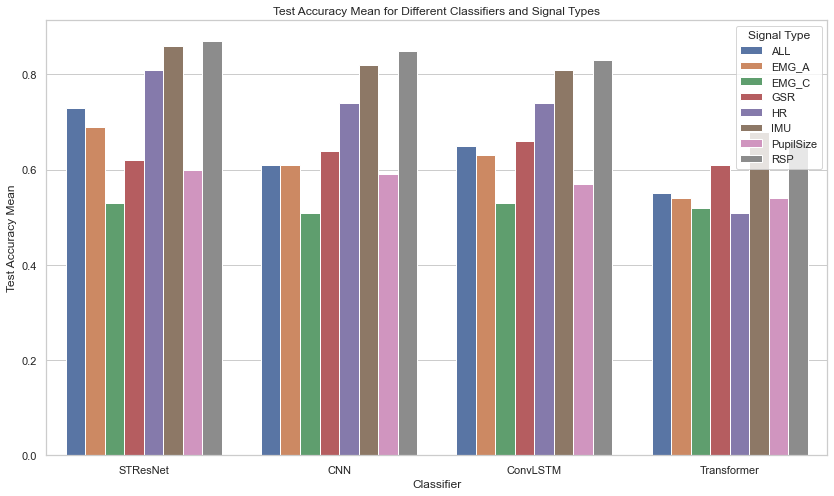

In [12]:
# Set the seaborn style
sns.set(style="whitegrid")

# Create a barplot using seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x="Classifier", y="Test acc mean", hue="Signal Type",  data=results_df)

# Add labels and title
plt.xlabel("Classifier")
plt.ylabel("Test Accuracy Mean")
plt.title("Test Accuracy Mean for Different Classifiers and Signal Types")

# Show the legend
plt.legend(title="Signal Type")

# Show the plot
plt.show()

In [ ]:
# Make a table with results per model with average and standard deviation
results_df = pd.DataFrame()

sensor_names = ['ALL', 'EMG_A', 'EMG_C', 'GSR', 'HR', 'IMU', 'PupilSize', 'RSP']

index_counter = 0

for sensor_name in sensor_names:
    # Load data
    test_acc_dict, _ = load_data(sensor_name)

    # Process and add results to the dataframe
    for model_name, test_acc_arr in test_acc_dict.items():
        results_df.loc[index_counter, 'Signal Type'] = sensor_name
        results_df.loc[index_counter, 'Classifier'] = model_name
        results_df.loc[index_counter, 'Test acc mean'] = np.mean(test_acc_arr)
        results_df.loc[index_counter, 'Test acc std'] = np.std(test_acc_arr)

        index_counter += 1

# Round the values in the dataframe
results_df = results_df.round(2)
results_df = results_df[results_df['Classifier']!='LSTM']
results_df

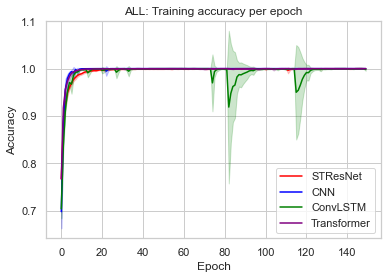

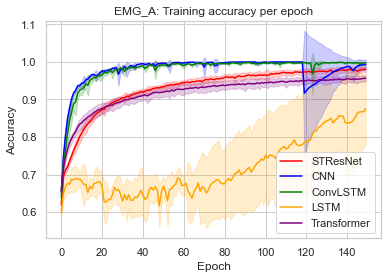

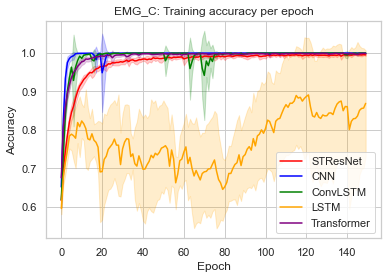

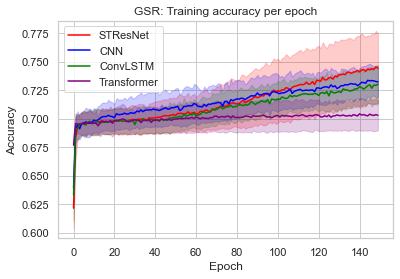

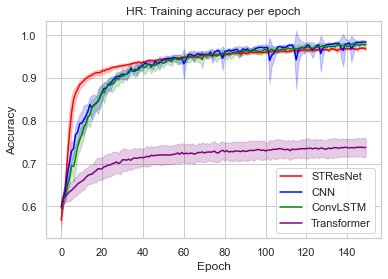

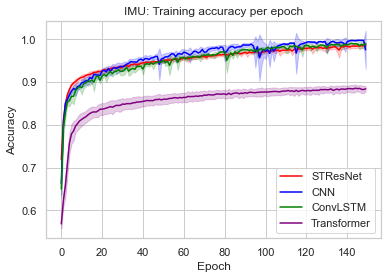

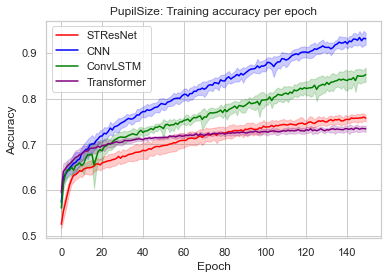

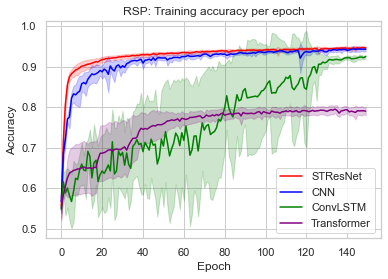

In [17]:
#plt average accuracy withper epoch with
model_colors = {'CNN': 'blue', 'STResNet': 'red', 'ConvLSTM': 'green', 'LSTM': 'orange', 'Transformer': 'purple'}
#plt.figure(figsize=(10,5))


for sensor_name in sensor_names:
    plt.title(sensor_name + ': Training accuracy per epoch')
    # Load data
    _, history_dict = load_data(sensor_name)

    for model_name, history_arr in history_dict.items():
        model_acc_arr = []
        for history in history_arr:
            if model_name == 'STResNet':
                fold_acc = history['acc']
            else:
                fold_acc = history['accuracy']
            model_acc_arr.append(fold_acc)
        
        plt.plot(np.mean(model_acc_arr, axis=0), color=model_colors[model_name], label=model_name)
        #plot shaded confidence
        mean = np.mean(model_acc_arr, axis=0)
        std = np.std(model_acc_arr, axis=0)
        plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.2, color=model_colors[model_name])
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()


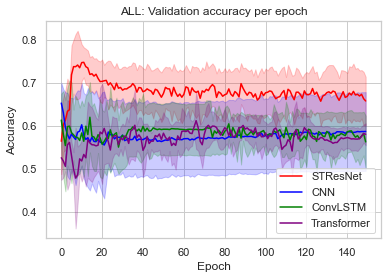

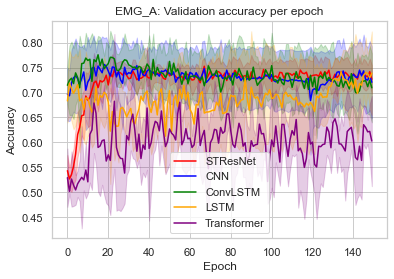

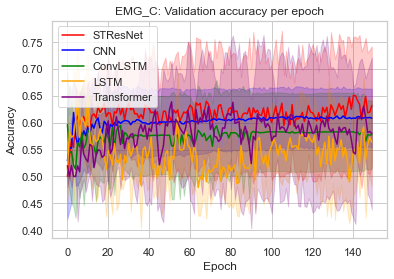

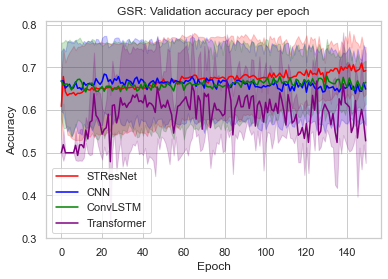

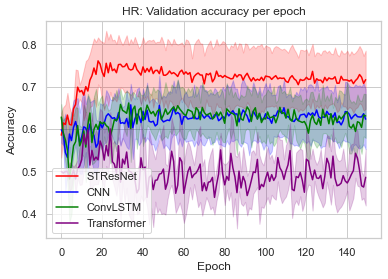

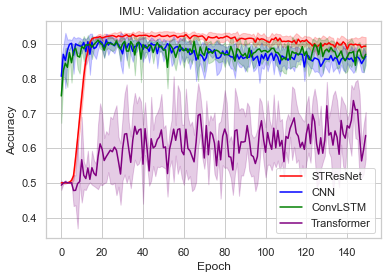

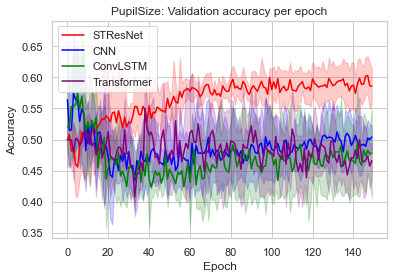

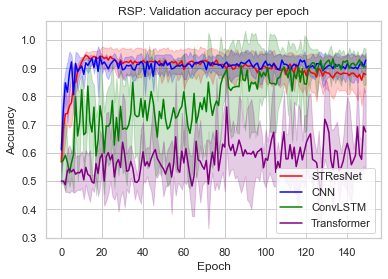

In [20]:
#plt average accuracy withper epoch with
model_colors = {'CNN': 'blue', 'STResNet': 'red', 'ConvLSTM': 'green', 'LSTM': 'orange', 'Transformer': 'purple'}

for sensor_name in sensor_names:
    plt.title(sensor_name + ': Validation accuracy per epoch')
    # Load data
    _, history_dict = load_data(sensor_name)

    for model_name, history_arr in history_dict.items():
        model_acc_arr = []
        for history in history_arr:
            if model_name == 'STResNet':
                fold_acc = history['val_acc']
            else:
                fold_acc = history['val_accuracy']
            model_acc_arr.append(fold_acc)
        
        plt.plot(np.mean(model_acc_arr, axis=0), color=model_colors[model_name], label=model_name)
        #plot shaded confidence
        mean = np.mean(model_acc_arr, axis=0)
        std = np.std(model_acc_arr, axis=0)
        plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.2, color=model_colors[model_name])
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
